In [23]:
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install wordcloud --quiet
!pip install plotly --quiet

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
import pandas as pd
import numpy as np

In [25]:
#filename = "../raw_data/20220601_larger_data_b_scraped_clean.csv"
#data = pd.read_csv(filename).drop(columns = {'Unnamed: 0', 'Content'})#.iloc[0:100]
filename = "../raw_data/20220602.csv"
data = pd.read_csv(filename).drop(columns = {'Unnamed: 0'})
data['date'] = pd.to_datetime(data['date'])
data = data[~data['dir_1'].isna()].reset_index().drop(columns = "index") # drop rows that have NA in dir_1 column
data.head(2)

,title,cellar,date,dir_code,dir_1,dir_2,dir_3,dir_4,dir_5,dir_6
0,Commission Regulation (EU) No 965/2012 of 5 Oc...,3cb645b2-2a23-43c9-b842-b03665a6733a,2013-06-26,74030.0,Transport policy,Air transport,Air safety,NaN,NaN,NaN
1,Regulation (EU) No 600/2014 of the European Pa...,3b729ddf-f1f7-11e3-8cd4-01aa75ed71a1,2014-06-12,6202025.0,Right of establishment and freedom to provide ...,Sectoral application,Service activities,Stock exchanges and other securities markets,NaN,NaN


**Data exploration**

<AxesSubplot:xlabel='date', ylabel='Count'>

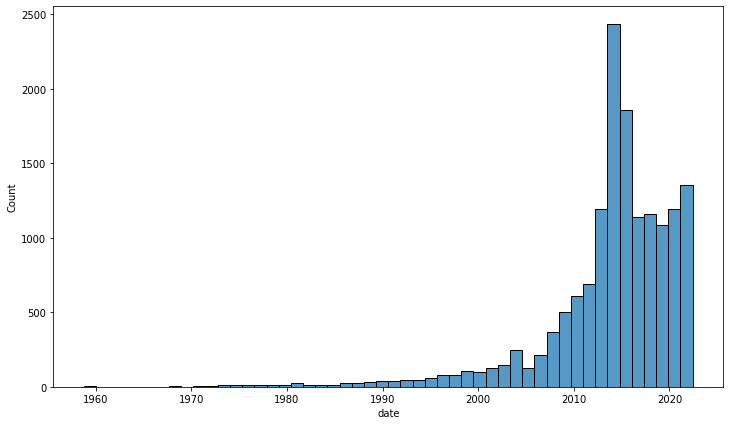

In [26]:
fig = plt.figure(figsize=(12,7))
sns.histplot(data['date'], bins = 50)

In [27]:
data['dir_1'].value_counts()

Agriculture                                                   4054
Environment, consumers and health protection                  2118
External relations                                            1377
Customs Union and free movement of goods                      1375
Fisheries                                                     1295
Common Foreign and Security Policy                            1196
Industrial policy and internal market                         1140
Right of establishment and freedom to provide services         568
Transport policy                                               559
General, financial and institutional matters                   327
Economic and monetary policy and free movement of capital      232
Area of freedom, security and justice                          229
Freedom of movement for workers and social policy              194
Regional policy and coordination of structural instruments     133
Energy                                                        

**USER INPUT**

In [28]:
# define a start-and end-date
start_date = datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')
end_date = datetime.datetime.strptime("2021-12-31", '%Y-%m-%d')
data_subset = data[np.logical_and(data['date'] >= start_date, data['date'] <= end_date)]

# uncomment this line if no time-subset is wanted
#data_subset = data

# select the sampling method
timesampling = "Y" # "M" for month, "Y" for year

**Data Preprocessing**

In [29]:
# categories (dir_1) in descending frequencies
dir_1 = data['dir_1'].value_counts().index

In [30]:
#create dataframe for the others to append to and rename col to dir name
df = data_subset[data_subset['dir_1'] == dir_1[0]].resample(timesampling, on='date')['title'].count().reset_index().rename(columns={'title':dir_1[0]})

# create dataframe with publications per topic
for i in range(1,len(dir_1)):
    category = dir_1[i]
    temp = data_subset[data_subset['dir_1'] == category].resample(timesampling, on='date')['title'].count().reset_index().rename(columns={'title':category})
    df = df.merge(temp, how='left', on='date').fillna(0)
data_publications = pd.concat([df['date'], df.drop(columns = "date").astype('Int64')], axis=1)

**Data Visualization**

Comparison of Topic Frequency in Pie Chart

In [47]:
piedata = data_publications.drop(columns='date').sum().reset_index()

fig = px.pie(piedata, values=0, names='index', title='Topics of published documents')
#fig.update_layout(hovermode="x")
fig.show()

Lineplot over Time (selected Categories)

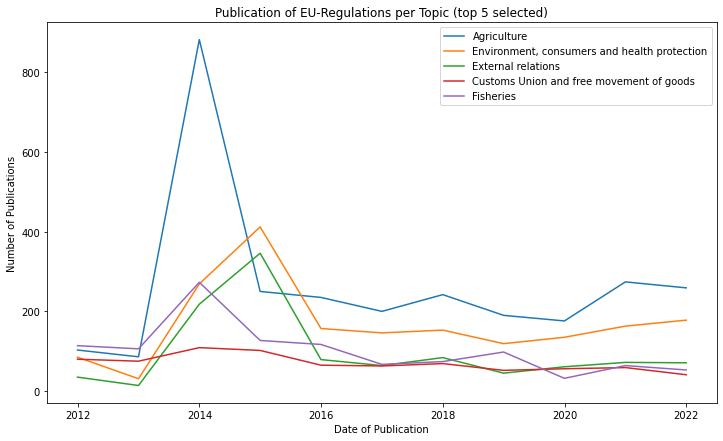

In [19]:
fig = plt.figure(figsize=(12,7))
subset = dir_1[0:5]
for i in subset:
    sns.lineplot(data = data_publications, x = 'date', y = i)
plt.xlabel("Date of Publication")
plt.ylabel("Number of Publications")
plt.legend(data_publications.drop(columns = "date").columns)
plt.title(f"Publication of EU-Regulations per Topic (top {len(subset)} selected)")
plt.show()

Stacked Area Chart

In [49]:
# prepare data
x = data_publications['date'].tolist() 
y = data_publications.drop(columns = {"date"}).T.values.tolist()
labels = data_publications.drop(columns = {"date"})

# create dict for the labels in plotly
newnames = {}
for index in range(0,len(labels.columns)):
    newnames[f"wide_variable_{str(index)}"] = labels.columns[index]

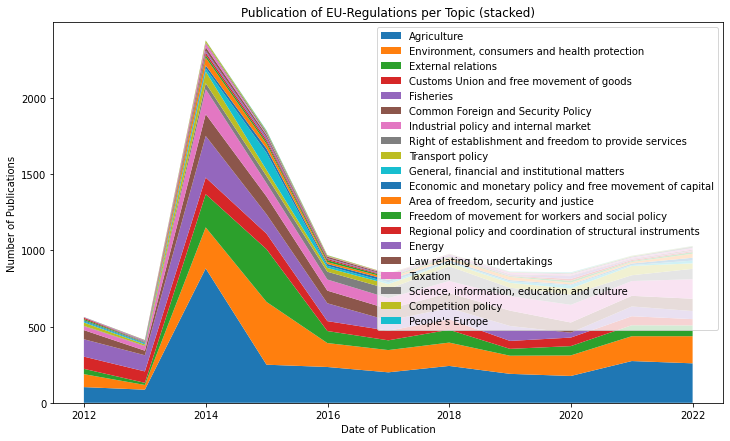

In [50]:
# matplotlib
fig = plt.figure(figsize=(12,7))
plt.stackplot(x,y, labels=labels)
plt.legend()
plt.xlabel("Date of Publication")
plt.ylabel("Number of Publications")
plt.title(f"Publication of EU-Regulations per Topic (stacked)")
plt.show()

In [22]:
# plotly
x_plot = x.copy()
y_plot = y.copy()
fig = px.area(x=x_plot, y=y_plot,
              labels={"x": "Date of Publication",
                     "value": "Number of Publications",
                     "variable": "Category"},
              title='Publication of EU-Regulations per Topic (stacked)')
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.show()

Stacked Area Chart Normalized

In [51]:
# prepare data

#normalize 
df = data_publications.drop(columns = {'date'})
data_publications_normalized = df.div(df.sum(axis=1), axis=0)
y_norm = data_publications_normalized.T.values.tolist()

x_norm = x.copy() # see chapter above
labels = labels.copy() # see chapter above
newnames = newnames.copy() # dict for labels in plotly, see chapter above

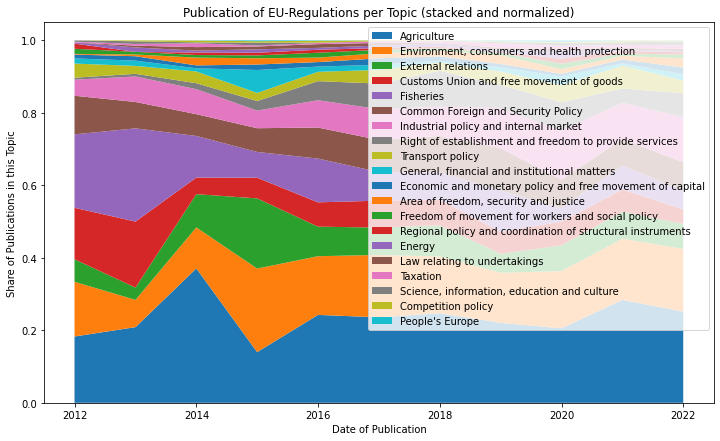

In [52]:
# matplotlib
fig = plt.figure(figsize=(12,7))
plt.stackplot(x_norm, y_norm, labels=labels)
plt.legend()
plt.xlabel("Date of Publication")
plt.ylabel("Share of Publications in this Topic")
plt.title(f"Publication of EU-Regulations per Topic (stacked and normalized)")
plt.show()

In [25]:
# plotly
x_norm_plot = x_norm.copy()
y_norm_plot = y_norm.copy()
fig = px.area(x=x_norm_plot, y=y_norm_plot,
              labels={"x": "Date of Publication",
                     "value": "Share of Publications in this Topic",
                     "variable": "Category"},
              title='Publication of EU-Regulations per Topic (stacked and normalized)')
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.show()